## SynDiffix Demo

This demo emulates how SynDiffix could be used if it were implemented in SQL. 

To emulate this, what we have done is pre-synthesized different combinations of columns and cached the results. In a real implementation, `SELECT col1, col2 FROM table` would cause only columns `col1` and `col2` to be synthesized. Likely the result would be cached, and subsequent operations on the same two columns would use the cached synthesized data. This demo essentially mimics queries to the cached syntheses.

### Tables

This demo looks at two datasets, the `census` dataset and the `taxi` dataset. We'll learn more about those datasets as we go.

In [100]:
import combsTables
import pandas as pd
import matplotlib.pyplot as plt
qh = combsTables.queryHandler()

### Comparing synthetic and original data

In this notebook, we frequently make comparisions between the original and synthetic data. In practice, for an untrusted user, this won't be possible. However, it will be possible to provide an indication as to the accuracy of the synthetic data, both in terms of coverage and numeric accuracy.

### SELECT * FROM census

The first thing a user is likely to do when encountering a new dataset is to inspect the first few rows of data. We do that here for the census data.

Note that with SynDiffix, the more columns you synthesize, the worse the accuracy per-column. Therefore, `SELECT *` is useful for an initial inspection of the data values, but should not be used for statistical analysis of specific parts of the data. (On the other hand, it should also be used for ML modeling use cases, but at the moment we are not emulating that.)

The following code (`qh.query(sql)`) is used to generate results for both the original and synthesized data. We do that here so that we can compare the two. Naturally in a real setting with an untrusted user, the original data would not be returned. `qh.query(sql)` also selects the appropriate cached synthetic dataset to use. It does this by inspecting the columns selected in the query, and selecting the synthetic table that has only those columns.

In [101]:
sql = "SELECT * FROM census_orig_ LIMIT 5"
dfOrigAll, dfSynAll = qh.query(sql)

Here are the first 5 rows of the original data:

In [102]:
print(dfOrigAll.to_string())

   index   age             class of worker  detailed industry recode  detailed occupation recode                            education  wage per hour enroll in edu inst last wk   marital stat                major industry code            major occupation code                         race     hispanic origin     sex member of a labor union reason for unemployment full or part time employment stat  capital gains  capital losses  dividends from stocks     tax filer stat region of previous residence state of previous residence       detailed household and family stat detailed household summary in household migration code-change in msa migration code-change in reg migration code-move within reg     live in this house 1 year ago migration prev res in sunbelt  num persons worked for employer family members under 18 country of birth father country of birth mother country of birth self                                  citizenship  own business or self employed fill inc questionnaire for veteran'

And here they are for the synthesized data:

In [103]:
print(dfSynAll.to_string())

   index   age   class of worker  detailed industry recode  detailed occupation recode                   education  wage per hour enroll in edu inst last wk   marital stat           major industry code                  major occupation code   race hispanic origin     sex member of a labor union reason for unemployment full or part time employment stat  capital gains  capital losses  dividends from stocks tax filer stat region of previous residence state of previous residence       detailed household and family stat detailed household summary in household migration code-change in msa migration code-change in reg migration code-move within reg     live in this house 1 year ago migration prev res in sunbelt  num persons worked for employer family members under 18 country of birth father country of birth mother country of birth self                        citizenship  own business or self employed fill inc questionnaire for veteran's admin  veterans benefits  weeks worked in year  year    

We an see from this that a user can "see" the data perfectly well from the anonymized data. (Note that for columns with many unique values, this won't be the case.)

### Basic statistics for continuous columns

Most of the `census` data is categorical, but a few columns have continuous data. Let's look at a variety of statistics for `age`.

In [104]:
sql = '''
SELECT count(age) as count,
       count(distinct age) as distinct,
       avg(age) as avg,
       stddev(age) as stdev,
       min(age) as min,
       max(age) as max
FROM census_orig_'''
dfOrig, dfSyn = qh.query(sql)

In [105]:
print(dfOrig.to_string())

    count  distinct        avg      stdev  min   max
0  209499        91  34.545592  22.329496  0.0  90.0


In [106]:
print(dfSyn.to_string())

    count  distinct       avg      stdev  min   max
0  209498        91  34.54602  22.329791  0.0  90.0


As can be seen from the above, the basic statistics for the original and synthesized data over the age column are extremely close. In this particular case, there are enough examples of every age that no ages were suppressed (the number of distinct ages are the same), and the min and max are also correct.

### Histogram of ages
Let's look at a histogram of ages, grouped by 10. We use a little math to specify the grouping.

In [107]:
sql = '''
SELECT (floor(age/10))*10 as age_by_10,
       count(*) as cnt
FROM census_orig_
GROUP BY 1
'''
dfOrig, dfSyn = qh.query(sql)

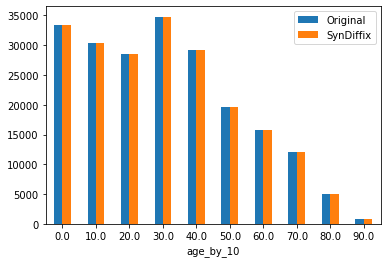

In [108]:
df = pd.merge(dfOrig, dfSyn, on='age_by_10')
df = df.rename(columns={'cnt_x': 'Original', 'cnt_y': 'SynDiffix'})
ax = df.plot(kind='bar', x='age_by_10', rot=0)

Of course, when the counts are large, the error is very small (here imperceptable).

## Race and education

Let's see if we can tease out the rationship between race and education. Let's start by looking at the distribution of each column.

In [109]:
sql = '''
SELECT education, count(*) as cnt
FROM census_orig_
GROUP BY 1
'''
dfOrig, dfSyn = qh.query(sql)

Let's use the following histogram to make sure that the synthetic data has the same number of categories as the original data, and is accurate. (Note again that a real system would provide this accuracy feedback.)

<AxesSubplot:xlabel='education'>

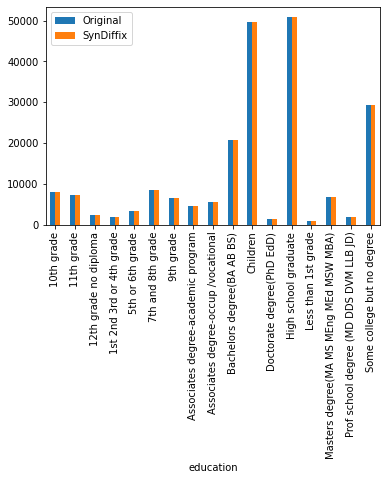

In [110]:
df = pd.merge(dfOrig, dfSyn, on='education')
df = df.rename(columns={'cnt_x': 'Original', 'cnt_y': 'SynDiffix'})
df.plot(kind='bar', x='education')

There is a matching SynDiffix bar for every Original bar, so our synthetic data is good. Therefore to keep things simple, we can work with only the synthetic data in what follows.

There are a lot of different education levels here, so let's use `CASE` to categorize them.

In [117]:
sql = '''
SELECT concat(race, ',', edu_level) AS race_edu, cnt
FROM    (SELECT race,
		CASE
			WHEN education IN (
			'Less than 1st grade',
			'1st 2nd 3rd or 4th grade',
			'5th or 6th grade'
			) THEN '0-6'
			WHEN education IN (
			'7th and 8th grade',
			'9th grade',
			'10th grade',
			'11th grade',
			'12th grade no diploma'
			) THEN '07-11'
			WHEN education IN (
			'High school graduate'
			) THEN '12'
			WHEN education IN (
			'Associates degree-academic program',
			'Associates degree-occup /vocational',
			'Bachelors degree(BA AB BS)',
			'Masters degree(MA MS MEng MEd MSW MBA)',
			'Prof school degree (MD DDS DVM LLB JD)',
			'Doctorate degree(PhD EdD)',
			'Some college but no degree'
			) THEN '12+'
			ELSE 'NA'
		END AS edu_level,
		count(*) AS cnt
	FROM (SELECT education,
			CASE
				WHEN race = 'Amer Indian Aleut or Eskimo' THEN 'Other'
				WHEN race = 'Asian or Pacific Islander' THEN 'Other'
				ELSE race
			END AS race
		FROM census_orig_ ) t1
	GROUP BY 1,2 ) t2
'''
dfOrig, dfSyn = qh.query(sql)

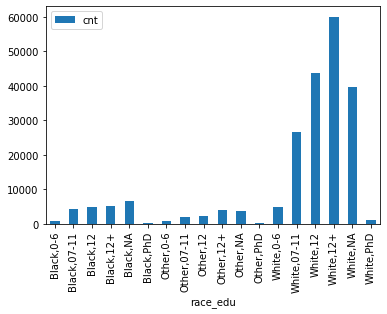

In [118]:
ax = dfSyn.plot(kind='bar', x='race_edu')

We see here that for Whites, there is a substantial increase with each higher education level, whereas for Blacks, in increase is far less.

Let's go ahead and compare original with synthetic and make sure everything is ok.

<AxesSubplot:xlabel='race_edu'>

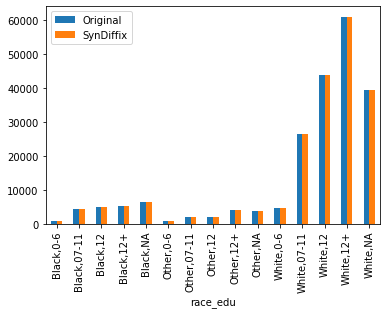

In [116]:
df = pd.merge(dfOrig, dfSyn, on='race_edu')
df = df.rename(columns={'cnt_x': 'Original', 'cnt_y': 'SynDiffix'})
df.plot(kind='bar', x='race_edu')

An important point from this example is that, using a synthetic data approach, any SQL can be used without limitation. 